Analysis the wind speed around the country with a view to windfarms

• You may look for your own source of historic weather information, and/or use the Met Eireann one (Historical Data - Met Éireann

- The Irish Meteorological Service). Click on the download button to get a zip file that contains a CSV file.

• You may need to clean and normalize the data before doing analysis

• Questions you can ask:

o How much wind power is there at a particular location?

▪ This is quite open ended, is this just the mean wind speed for an hour/day/month/year, or should you take into account that
there are wind ranges that the windfarms can operate in. (min max speeds)

▪ Some analysis of what power when would be useful (time of day/year)

o Are the wind speeds likely to be the same in 10 years in the future? ie is there a trend in recorded wind speeds over the last few decades.

o Is there any other weather metric worth analyzing (eg rain, temp)

o What will the power output of the windfarms in Ireland be like next week, according to the weather forecasts? (ok that is a tricky one, because you would need to get, or make up, information about the size and locations of the wind farms in Ireland, one find/makeup the windspeed to power output equation.



Steps:

1/ Download data (hourly) from given website. 

2/ Upload the files on Github

3/ Clean the file

- Remove all the rows above the Index row from the raw files

- Remove all the rows before the row where wdsp has its first value

4/ Review the variable 'wdsp', convert the measurement of wind speed from knot into m/s

5/ Add column 'dateonly' that contains dates (date-month-year) and column 'month' that contains months (month-year)

Ref: Wind power calculation
https://en.wikipedia.org/wiki/Wind_power

Ref:
Wind turbines will generally operate between 7mph (11km/h) and 56mph (90km/h). The efficiency is usually maximised at about 18mph (29km/h) and they will reach their maximum output at 27mph (43km/h).

https://www.nationalgrid.com/stories/energy-explained/wind-power-questions-answered#:~:text=Do%20turbines%20need%20fast%20wind,27mph%20(43km/h).


# Step 1: Upload data

The historical data hourly of 23 stations is downloaded from given website https://www.met.ie/climate/available-data/historical-data and stored in folder 'data' 


# Step 2: Clean the data

As the raw data in folder 'data' still contains uneccessary information. I need to clean the data I need to clean the data with function file_with_station. It allows to:
- delete all unneccessary first rows of the csv file
- 

In [2]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.stats import linregress




For later calculation, I convert the measurement of wind speed from knot into m/s

In [2]:
def file_with_station(file,station):

    # -------- Delete uneccessary rows ------------------------------
    # Read file as text
    with open(file, "r", encoding="utf-8") as f:
        lines = f.readlines()

    # Find the row number where the data starts i.e. the row that contain 'date' in its first column
    header_row = None

    for i, line in enumerate(lines):
        # split on comma and strip spaces
        first_cell = line.split(",")[0].strip().lower()
        if first_cell == "date":
            header_row = i
            break

    # Read file as csv, delete uneccessary rows
    df = pd.read_csv(file, skiprows=header_row,low_memory=False)


    # --------- Keep only useful columns ----------------------------- 
    df = df[["date", "wdsp", "temp", "rain"]]

    # convert 'wdsp' to numeric
    df["wdsp"] = pd.to_numeric(df["wdsp"], errors="coerce")

    # find first row where wind speed is not NaN
    first_valid_value = df.loc[(df["wdsp"].notna()) & (df["wdsp"] != 0)].index.min()

    # drop rows before that
    df = df.loc[first_valid_value:].reset_index(drop=True)


    # --------- Fill up missing value ----------------------------------
    # modify the format of 'date'
    df['date'] = pd.to_datetime(df['date'], format='%d-%b-%Y %H:%M')

    # Set 'date' as index as interpolate based on actual time differences between index values
    df = df.set_index('date')

    # Interpolate missing windspeed (linear is best for meteorological data) -- I use AI to help me with this.
    df['wdsp'] = df['wdsp'].interpolate(method='time', limit_direction='both', limit_area='inside')

    
    # --------- Add new columns ---------------------------------------
    # Bring 'date' back as a column
    df = df.reset_index()

    # modify the format of 'date'
    #df['date'] = pd.to_datetime(df['date'], format='%d-%b-%Y %H:%M')

    # Add a column that contains only date details
    df['dateonly']= df['date'].dt.date

    # Add a column that contains only year
    df['year'] = pd.to_datetime(df['date']).dt.strftime('%Y')

    # Add a column that contains only month-year
    df['yearmonth'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m')

    # Add a column that contains only month
    df['month'] = pd.to_datetime(df['date']).dt.strftime('%m')

    # Add a column that contains only hour
    df['hour'] = pd.to_datetime(df['date']).dt.strftime('%H:%M')

    # convert the measurement of wdsp into m/s
    df["wdsp_ms"] = df["wdsp"] * 0.5144444444

    # Add a column which takes the station name as value
    df["station"]= station

    # convert 'temp' to numeric
    df["temp"] = pd.to_numeric(df["temp"], errors="coerce")
    R = 287.05       # J/(kg·K)
    p = 101325       # Pa (assumed constant)
    # Add column 'rho' - air density
    df["rho"] = p / (R * (df["temp"] + 273.15))

    # Add column 'power' - wind power density
    df['power'] = 0.5 * df["rho"] * df["wdsp_ms"]**3


    # --------- Save as a new file in folder stationdata ----------------
    df.to_csv(f"stationdata/{station}.csv", index=False)
    print(f"The file {station}.csv is now created.")

In [3]:
file_with_station("data/hly275.csv","MACE HEAD")
file_with_station("data/hly375.csv","OAK PARK")
file_with_station("data/hly518.csv","SHANNON AIRPORT")
file_with_station("data/hly532.csv","DUBLIN AIRPORT")
file_with_station("data/hly575.csv","MOORE PARK")
file_with_station("data/hly675.csv","BALLYHAISE")
file_with_station("data/hly775.csv","SHERKIN ISLAND")
file_with_station("data/hly875.csv","MULLINGAR")
file_with_station("data/hly1075.csv","ROCHES POINT")
file_with_station("data/hly1175.csv","NEWPORT")
file_with_station("data/hly1375.csv","DUNSANY")
file_with_station("data/hly1475.csv","GURTEEN")
file_with_station("data/hly1575.csv","MALIN HEAD")
file_with_station("data/hly1775.csv","JOHNSTOWN CASTLE 2")
file_with_station("data/hly1875.csv","ATHENRY")
file_with_station("data/hly1975.csv","MT DILLON")
file_with_station("data/hly2075.csv","FINNER")
file_with_station("data/hly2175.csv","CLAREMORRIS")
file_with_station("data/hly2275.csv","VALENTIA OBSERVATORY")
file_with_station("data/hly2375.csv","BELMULLET")
file_with_station("data/hly3904.csv","CORK AIRPORT")
file_with_station("data/hly4935.csv","KNOCK AIRPORT")

The file MACE HEAD.csv is now created.
The file OAK PARK.csv is now created.
The file SHANNON AIRPORT.csv is now created.
The file DUBLIN AIRPORT.csv is now created.
The file MOORE PARK.csv is now created.
The file BALLYHAISE.csv is now created.
The file SHERKIN ISLAND.csv is now created.
The file MULLINGAR.csv is now created.
The file ROCHES POINT.csv is now created.
The file NEWPORT.csv is now created.
The file DUNSANY.csv is now created.
The file GURTEEN.csv is now created.
The file MALIN HEAD.csv is now created.
The file JOHNSTOWN CASTLE 2.csv is now created.
The file ATHENRY.csv is now created.
The file MT DILLON.csv is now created.
The file FINNER.csv is now created.
The file CLAREMORRIS.csv is now created.
The file VALENTIA OBSERVATORY.csv is now created.
The file BELMULLET.csv is now created.
The file CORK AIRPORT.csv is now created.
The file KNOCK AIRPORT.csv is now created.


## Step 3: Wind speed study

/tmp/ipykernel_2340/42784998.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_2340/42784998.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_2340/42784998.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_2340/42784998.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_2340/42784998.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_2340/42784998.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_2340/42784998.py:5: Dtype

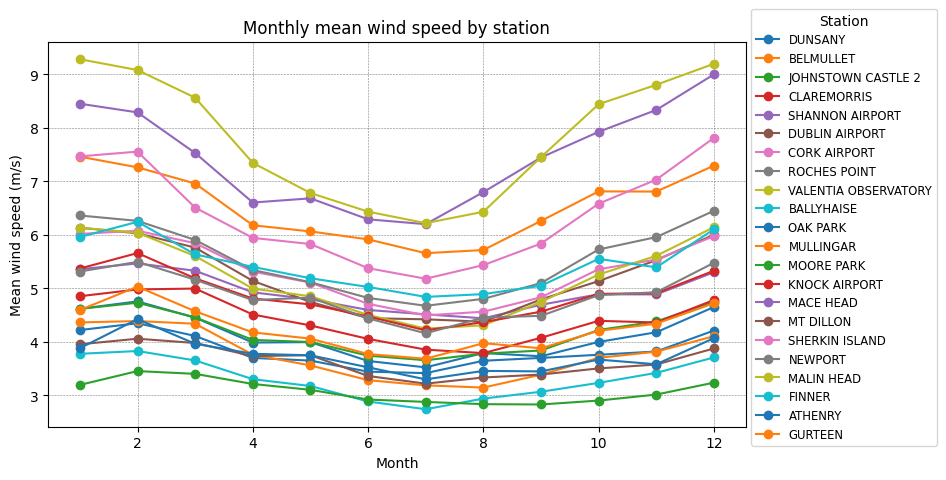

In [18]:
DATADIR = Path("stationdata")

plt.figure(figsize=(9, 5))
for file in DATADIR.glob("*.csv"):
    df = pd.read_csv(file)
    
    # Mean wind speed monthly
    monthly_wdsp = df.groupby("month")["wdsp_ms"].mean()
    
    # Use the file name (without extension) as the label
    monthly_wdsp.plot(marker='o', label=file.stem)

plt.xlabel("Month")
plt.ylabel("Mean wind speed (m/s)")
plt.title("Monthly mean wind speed by station")
plt.legend(title="Station", fontsize='small',bbox_to_anchor=(1,1.1))
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.4)

# put a copy of the image of the plot (.png file) into the `plot` folder in the root of my repository
plt.savefig(f"plot/Wind speed study - monthly mean windspeed.png")

plt.show()

/tmp/ipykernel_2340/1545871913.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_2340/1545871913.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_2340/1545871913.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_2340/1545871913.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_2340/1545871913.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_2340/1545871913.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_2340/15458719

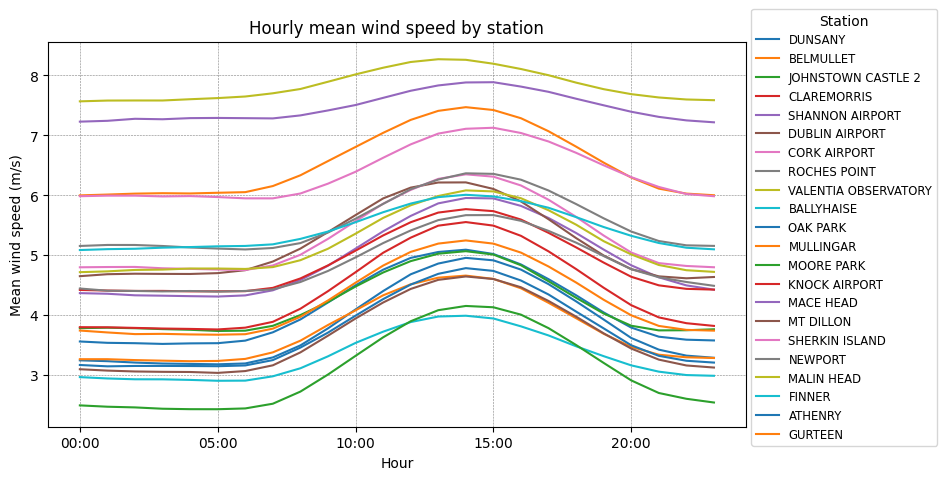

In [19]:
DATADIR = Path("stationdata")

plt.figure(figsize=(9, 5))
for file in DATADIR.glob("*.csv"):
    df = pd.read_csv(file)
    
    # Mean wind speed monthly
    hourly_wdsp = df.groupby("hour")["wdsp_ms"].mean()
    
    # Use the file name (without extension) as the label
    hourly_wdsp.plot(label=file.stem)

plt.xlabel("Hour")
plt.ylabel("Mean wind speed (m/s)")
plt.title("Hourly mean wind speed by station")
plt.legend(title="Station", fontsize='small',bbox_to_anchor=(1,1.1))
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.4)

# put a copy of the image of the plot (.png file) into the `plot` folder in the root of my repository
plt.savefig(f"plot/Wind speed study - hourly mean windspeed.png")

plt.show()

## Wind power density study

/tmp/ipykernel_2340/382864676.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_2340/382864676.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_2340/382864676.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_2340/382864676.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_2340/382864676.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_2340/382864676.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_2340/382864676.py:5

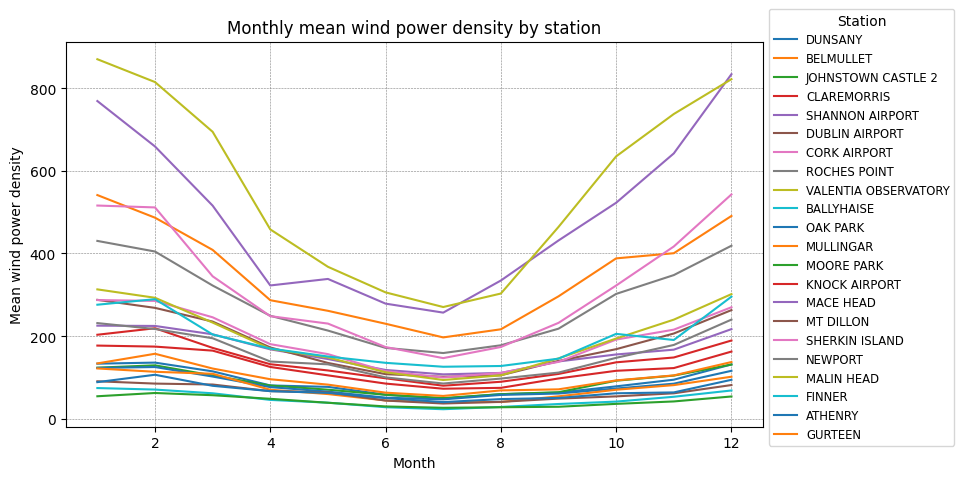

In [16]:
DATADIR = Path("stationdata")

plt.figure(figsize=(9, 5))
for file in DATADIR.glob("*.csv"):
    df = pd.read_csv(file)
    
    # Mean wind speed monthly
    monthly_power = df.groupby("month")["power"].mean()
    
    # Use the file name (without extension) as the label
    monthly_power.plot(label=file.stem)

plt.xlabel("Month")
plt.ylabel("Mean wind power density")
plt.title("Monthly mean wind power density by station")
plt.legend(title="Station", fontsize='small',bbox_to_anchor=(1,1.1))
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.4)

# put a copy of the image of the plot (.png file) into the `plot` folder in the root of my repository
plt.savefig(f"plot/Wind density study - monthly mean wind power density.png")

plt.show()

/tmp/ipykernel_2340/3951021770.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_2340/3951021770.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_2340/3951021770.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_2340/3951021770.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_2340/3951021770.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_2340/3951021770.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_2340/39510217

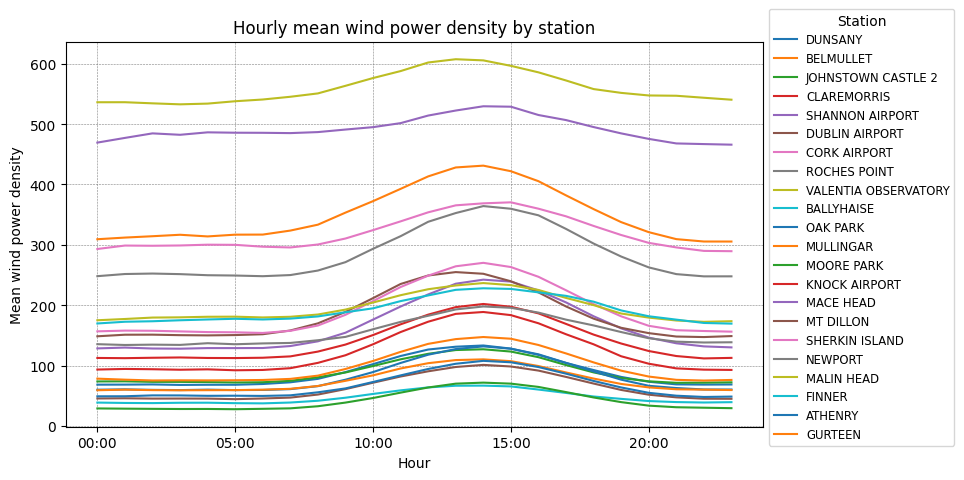

In [20]:
DATADIR = Path("stationdata")

plt.figure(figsize=(9, 5))
for file in DATADIR.glob("*.csv"):
    df = pd.read_csv(file)
    
    # Mean wind speed monthly
    hourly_power = df.groupby("hour")["power"].mean()
    
    # Use the file name (without extension) as the label
    hourly_power.plot(label=file.stem)

plt.xlabel("Hour")
plt.ylabel("Mean wind power density")
plt.title("Hourly mean wind power density by station")
plt.legend(title="Station", fontsize='small',bbox_to_anchor=(1,1.1))
plt.grid(color = 'grey', linestyle = '--', linewidth = 0.4)

# put a copy of the image of the plot (.png file) into the `plot` folder in the root of my repository
plt.savefig(f"plot/Wind density study - hourly mean wind power density.png")

plt.show()

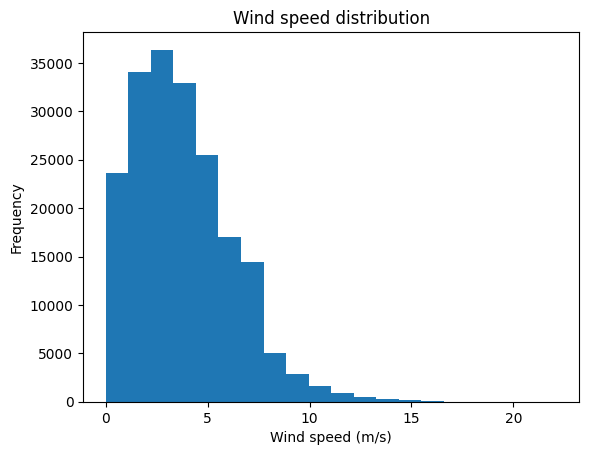

In [57]:
# Study wind speed range
plt.hist(oakpark["wdsp_ms"], bins=20)
plt.xlabel("Wind speed (m/s)")
plt.ylabel("Frequency")
plt.title("Wind speed distribution")
plt.show()

## monthly number of hours that turbins can operate
### TO DO: save pic

https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html


In [ ]:
# Define the wind range
# cut_in = 7
# optimum = 18     
# cut_out = 27 

/tmp/ipykernel_4033/604200473.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_4033/604200473.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_4033/604200473.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_4033/604200473.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_4033/604200473.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_4033/604200473.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_4033/604200473.py:4

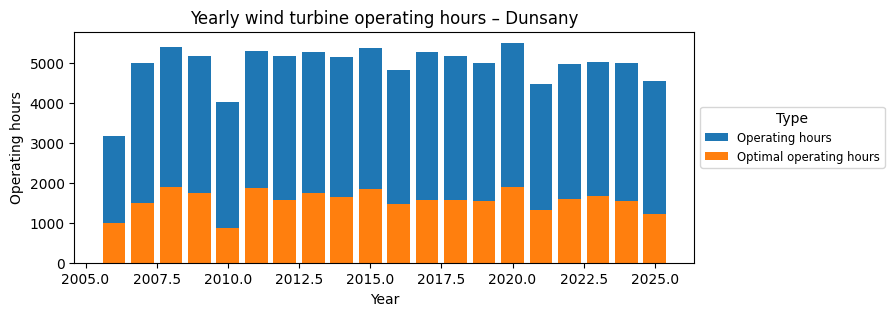

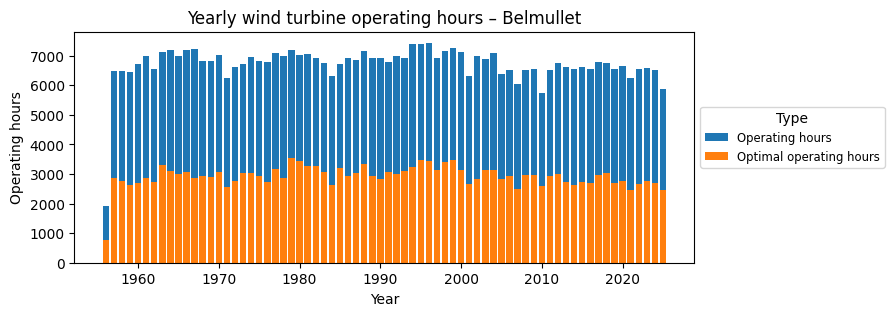

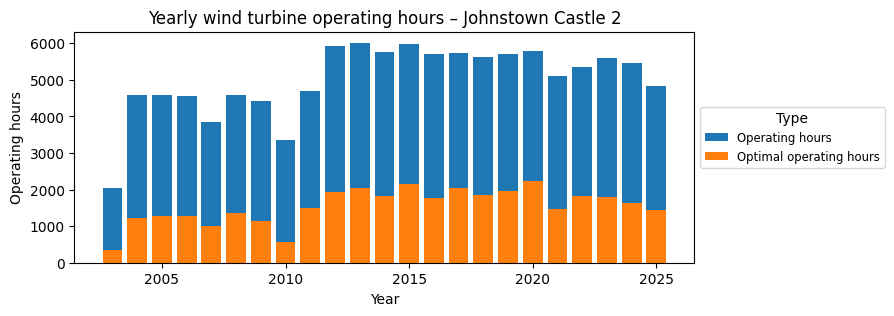

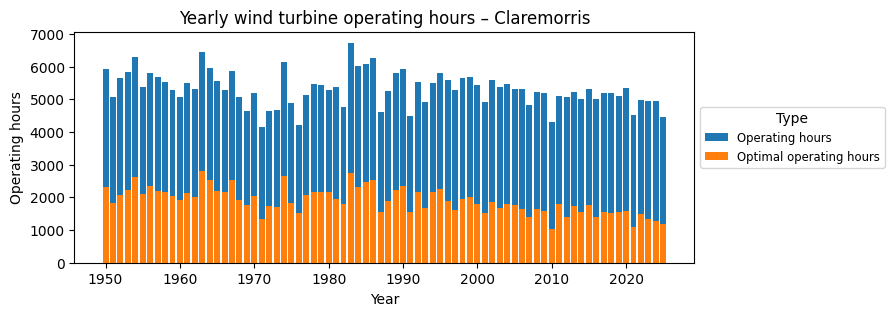

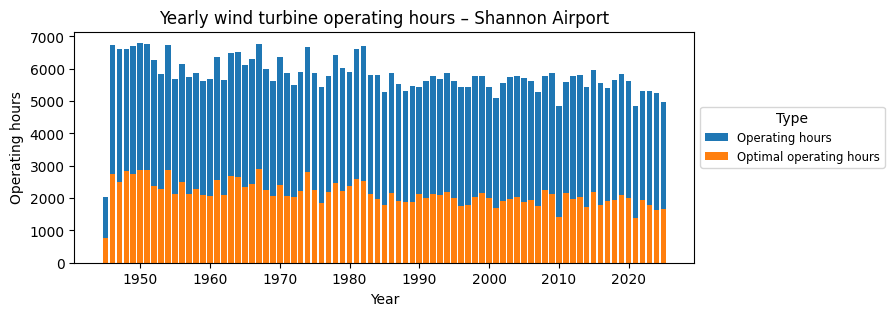

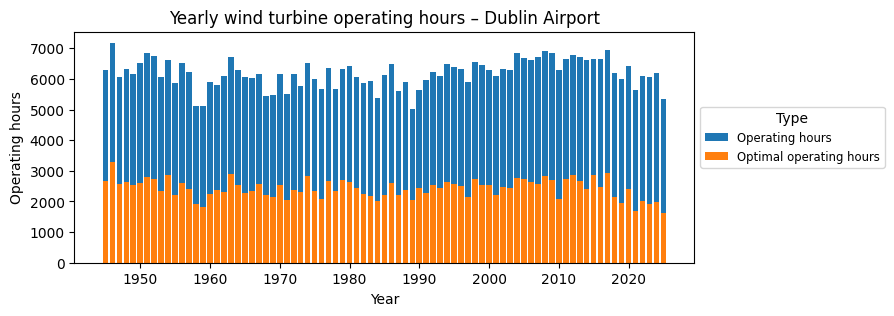

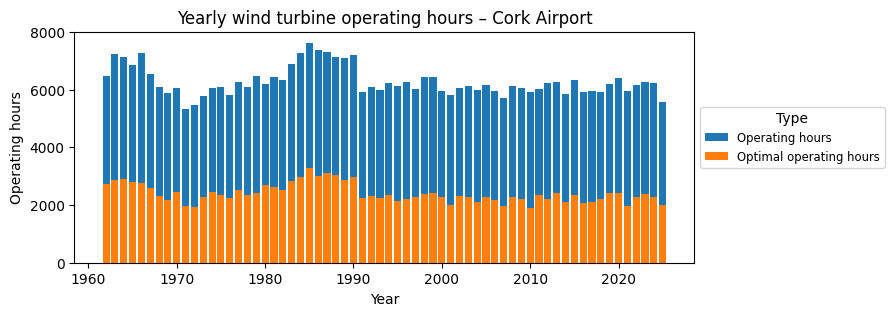

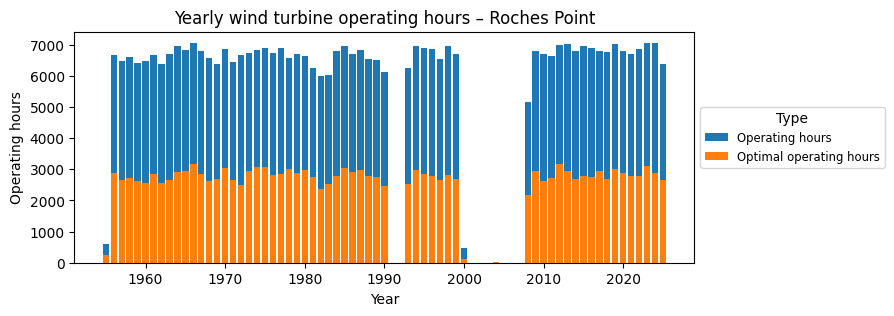

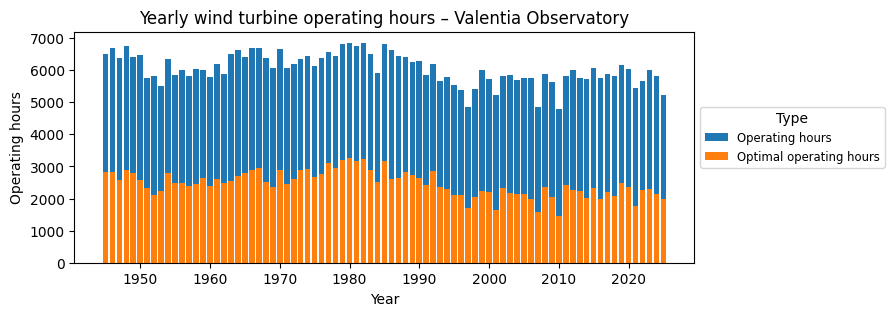

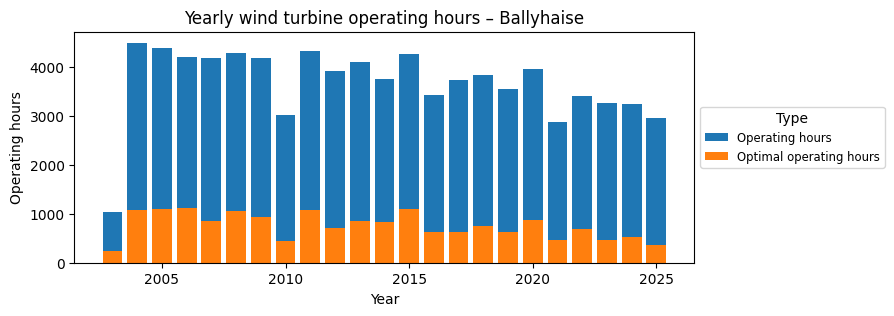

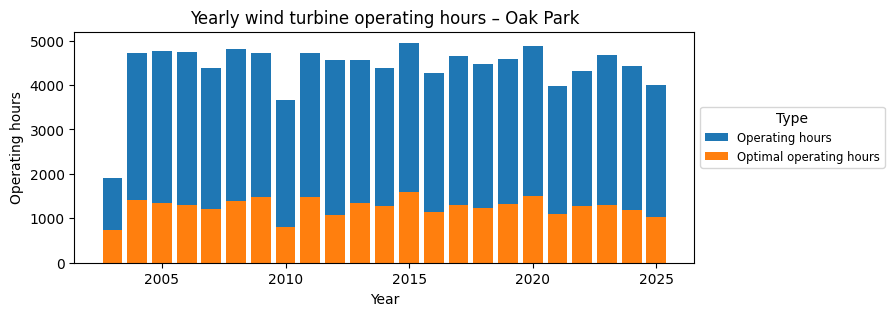

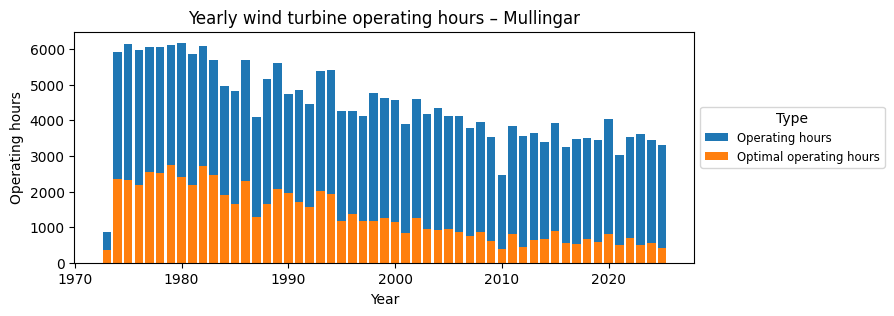

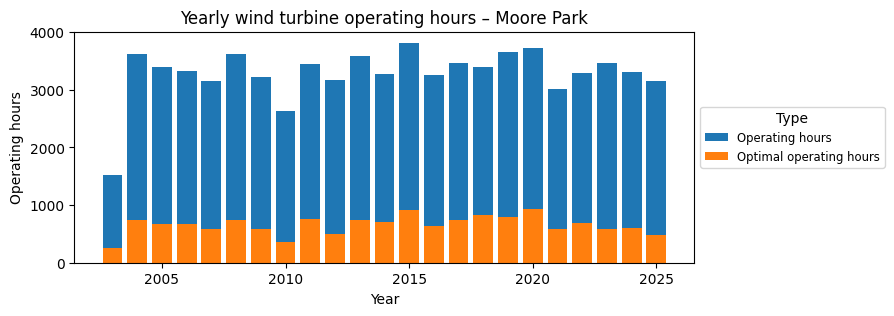

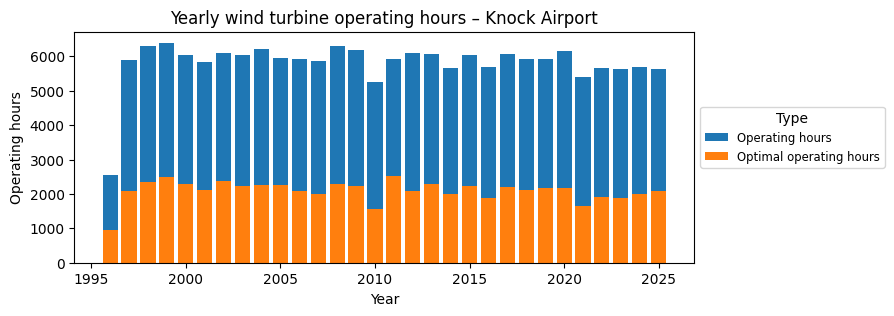

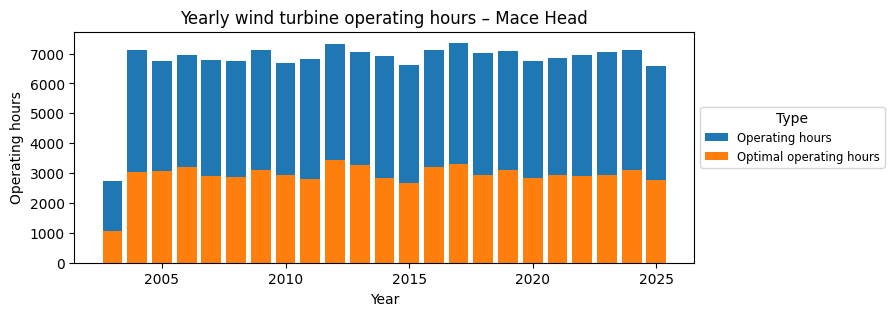

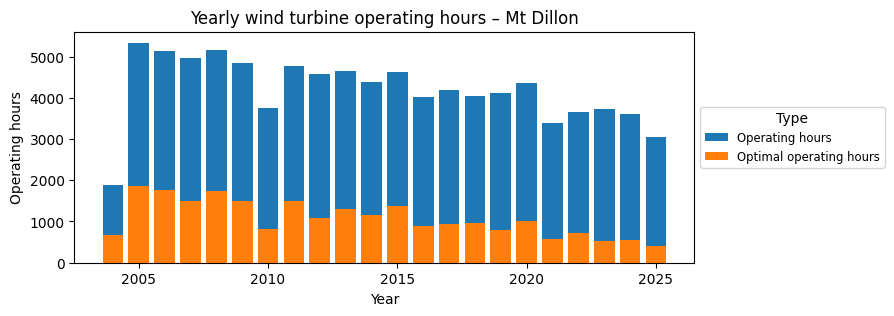

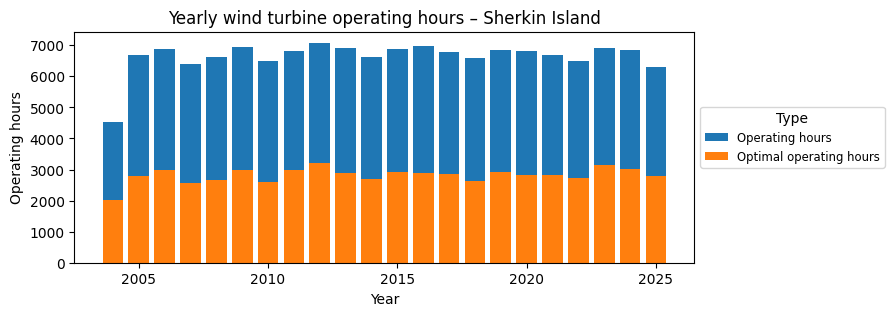

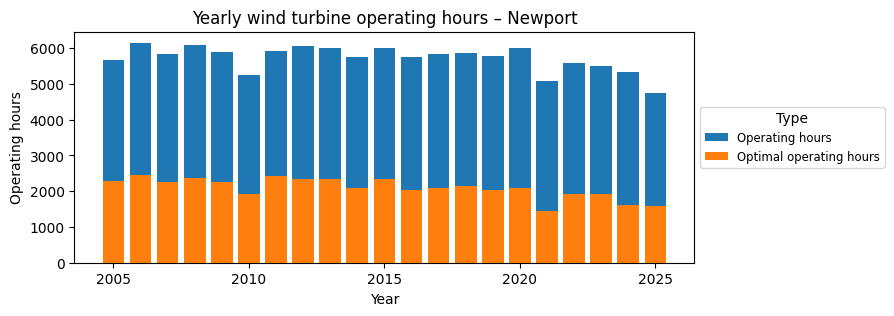

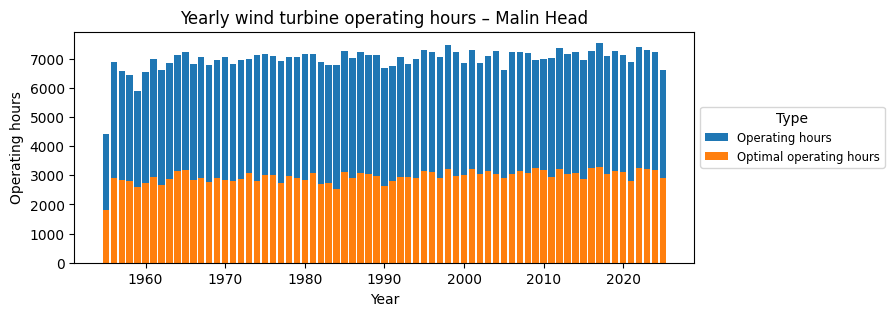

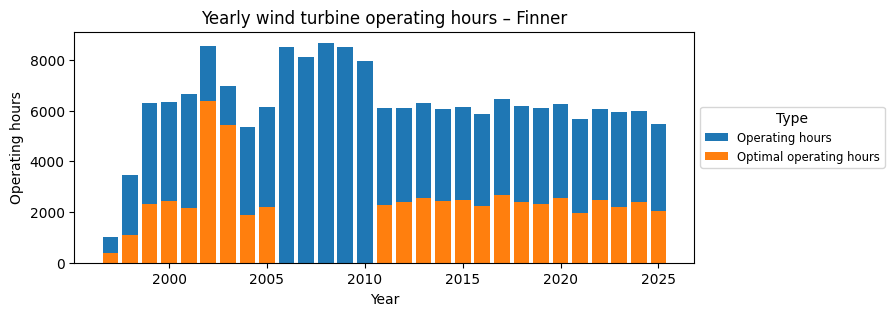

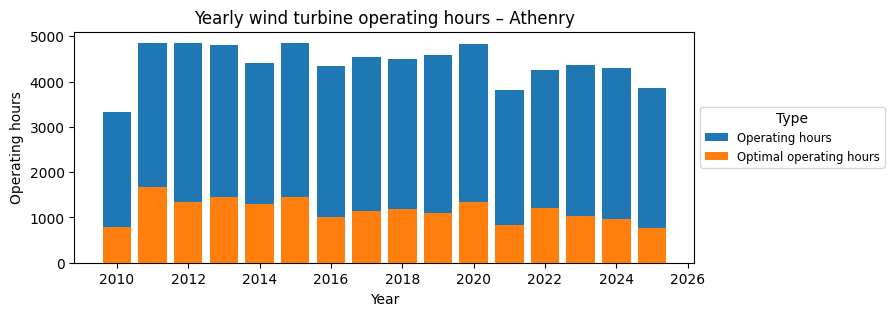

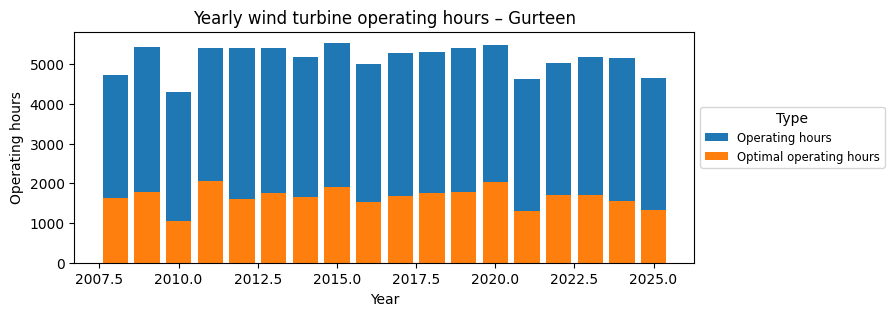

In [3]:
DATADIR = Path("stationdata")

for file in DATADIR.glob("*.csv"):
    df = pd.read_csv(file)
    
    # Study wind range for wind turbines operation
    df["operating"] = (df["wdsp"] >= 7) & (df["wdsp"] <= 27)
    df["optimal"]   = (df["wdsp"] >= 12) & (df["wdsp"] <= 18)

    # Number of hours of operation in total per year
    yearly_operating = df.groupby("year")["operating"].sum()
    # Number of hours of optimal production in total per year
    yearly_optimal= df.groupby("year")["optimal"].sum()

    fig, ax = plt.subplots(figsize=(8, 3))

    bars1 = ax.bar(yearly_operating.index, yearly_operating.values, label="Operating hours")

    bars2 = ax.bar(yearly_optimal.index, yearly_optimal.values, label="Optimal operating hours")

    station_name = file.stem.title()

    ax.set_xlabel("Year")
    ax.set_ylabel("Operating hours")
    ax.set_title(f"Yearly wind turbine operating hours – {station_name}")

    # value labels
    #ax.bar_label(bars1, fontsize=8, padding=3)
    #ax.bar_label(bars2, fontsize=8, padding=3)

    # legend
    ax.legend(title="Type", fontsize="small",bbox_to_anchor=(1,0.7))

# put a copy of the image of the plot (.png file) into the `plot` folder in the root of my repository
plt.savefig(f"plot/Operating hours study - yearly wind turbine operation hours.png")

plt.show()

/tmp/ipykernel_4033/3070047580.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_4033/3070047580.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_4033/3070047580.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_4033/3070047580.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_4033/3070047580.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_4033/3070047580.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_4033/30700475

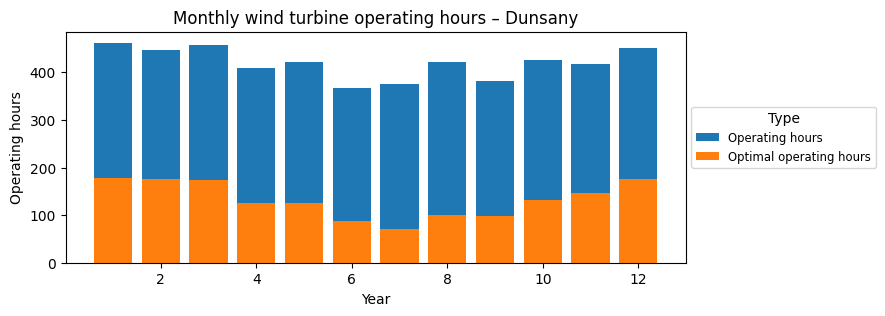

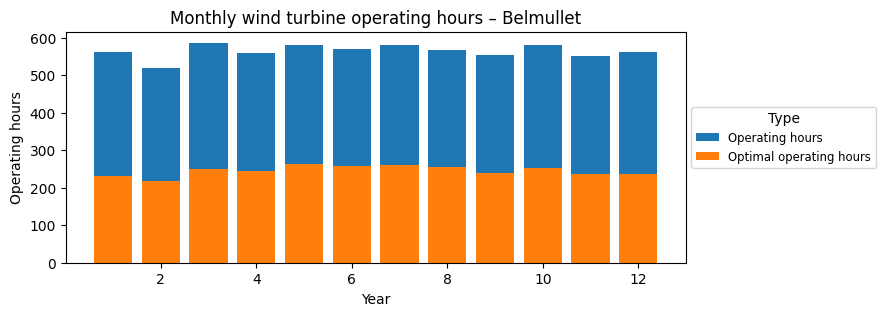

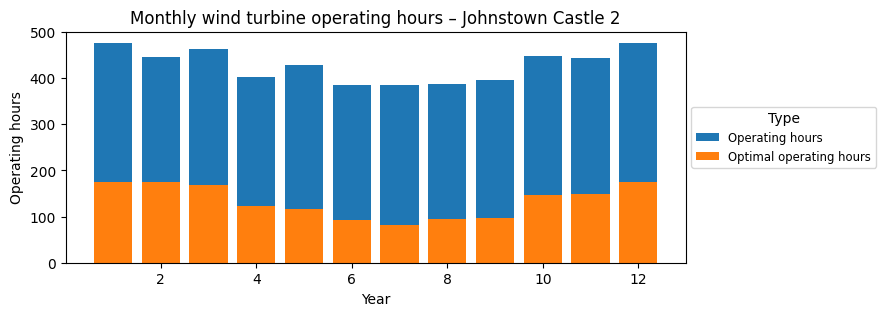

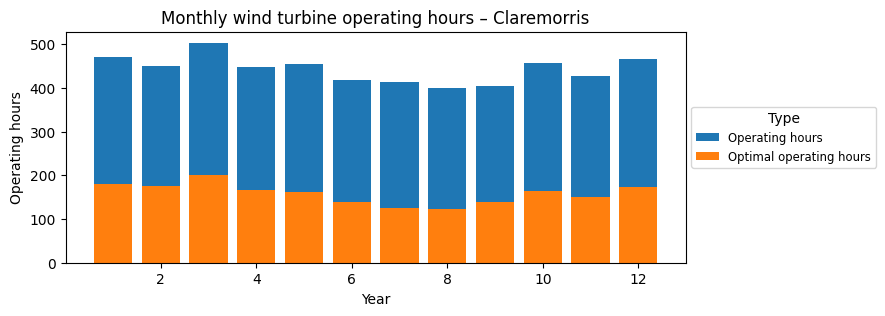

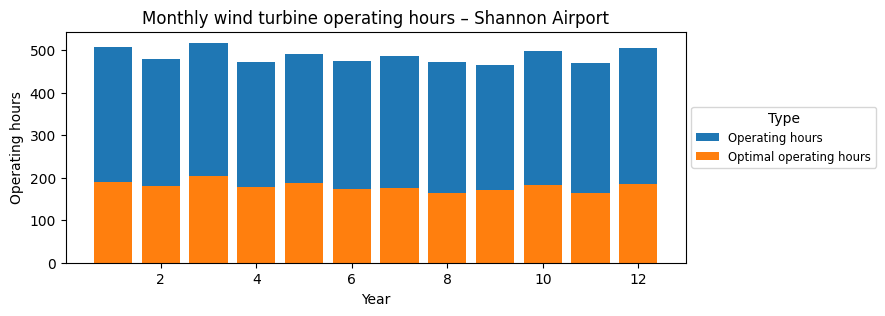

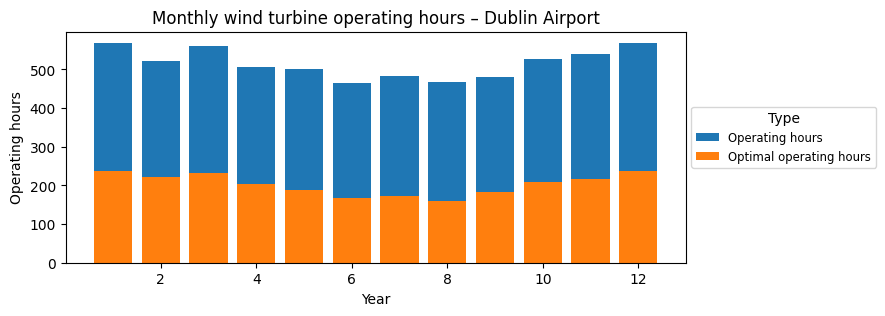

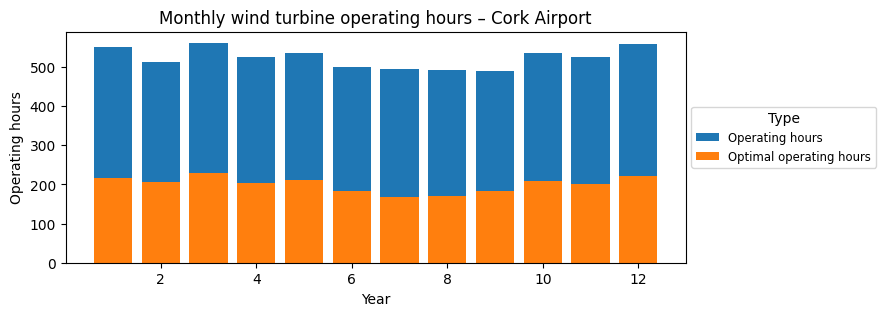

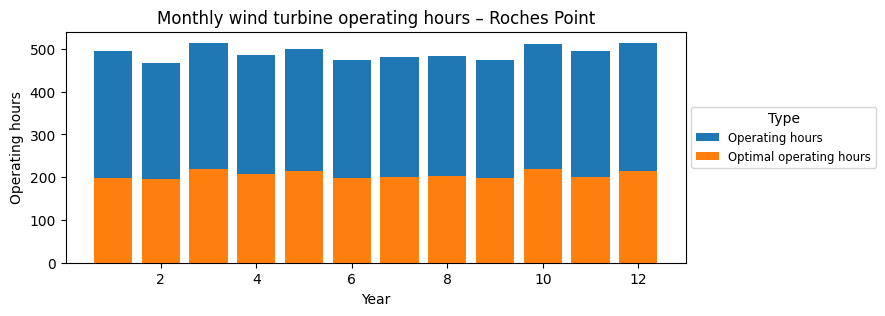

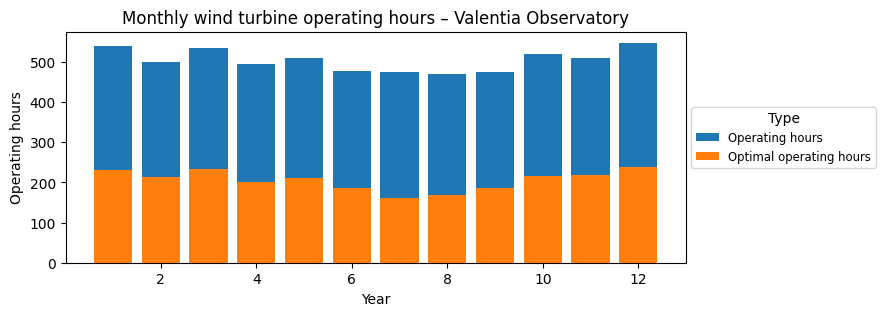

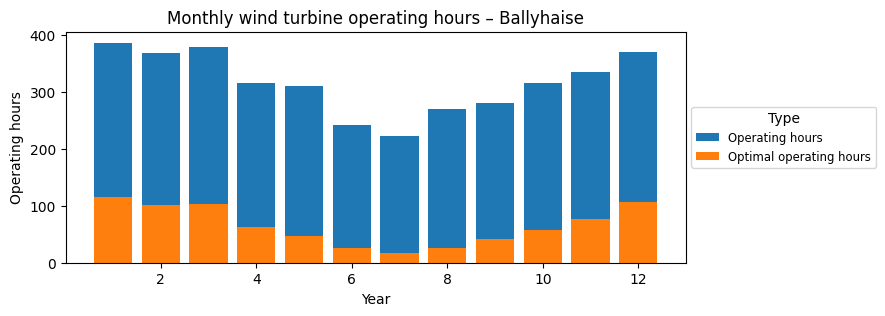

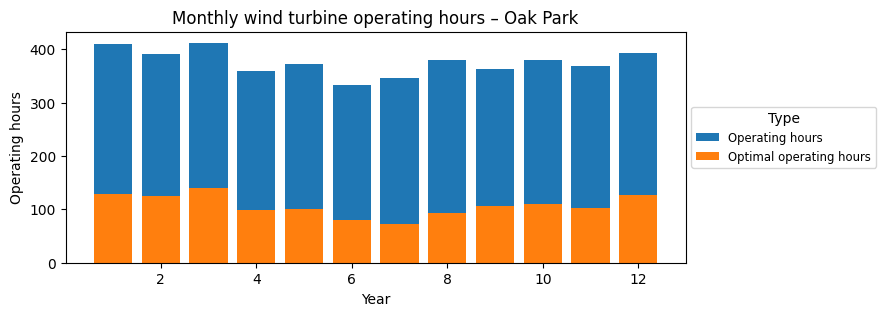

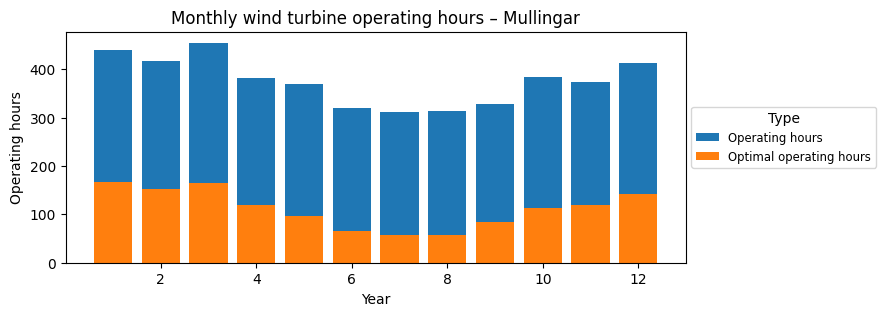

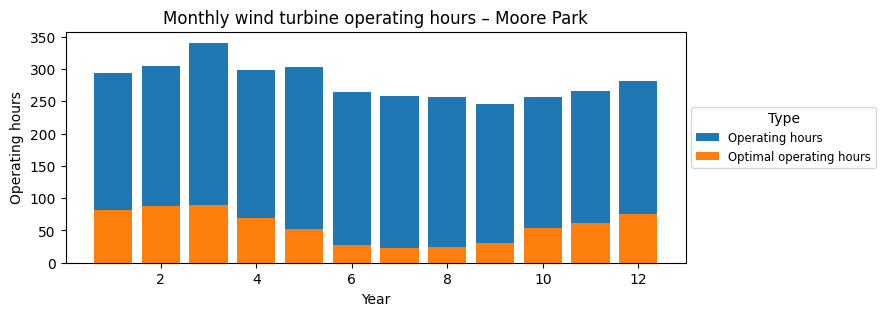

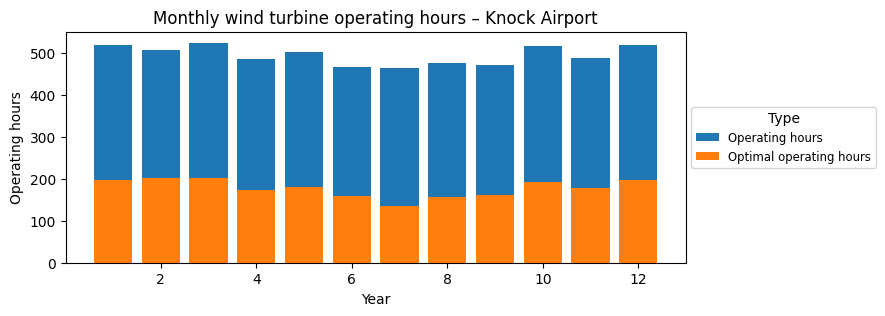

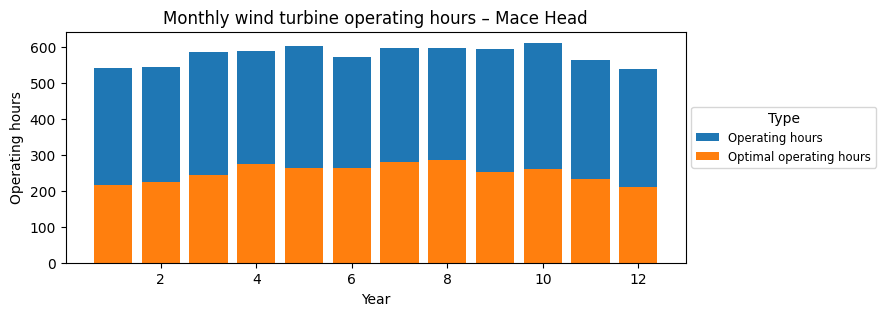

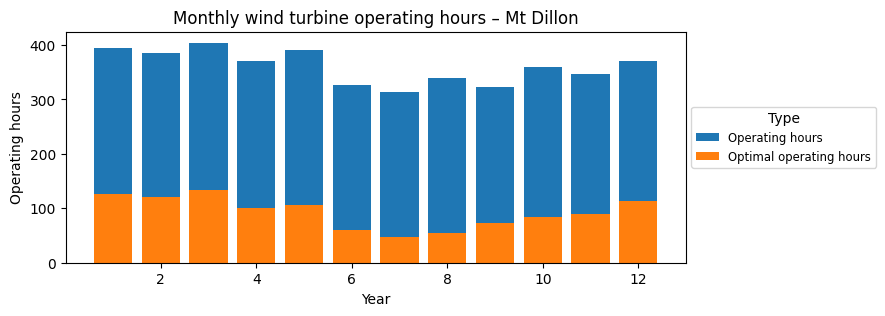

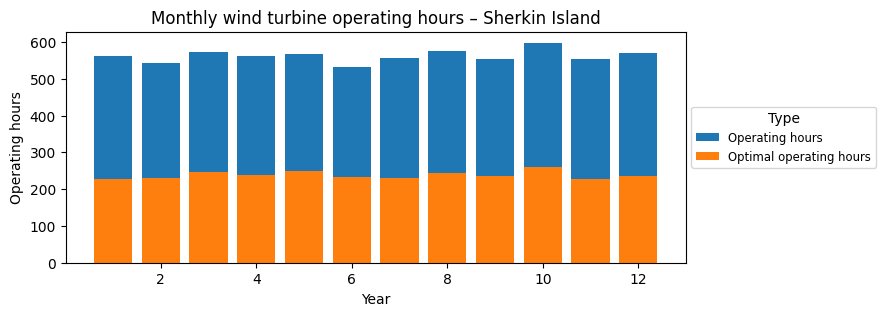

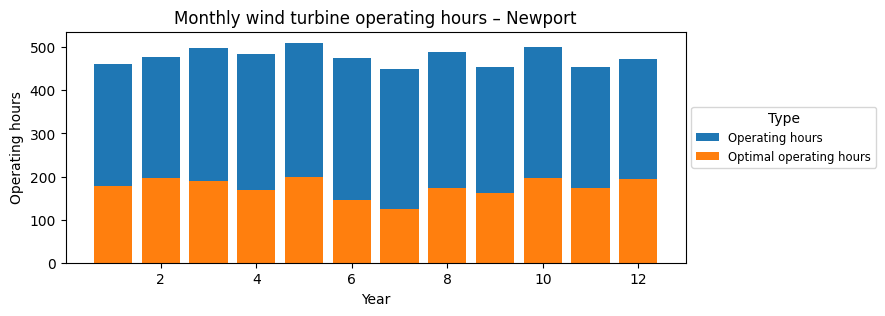

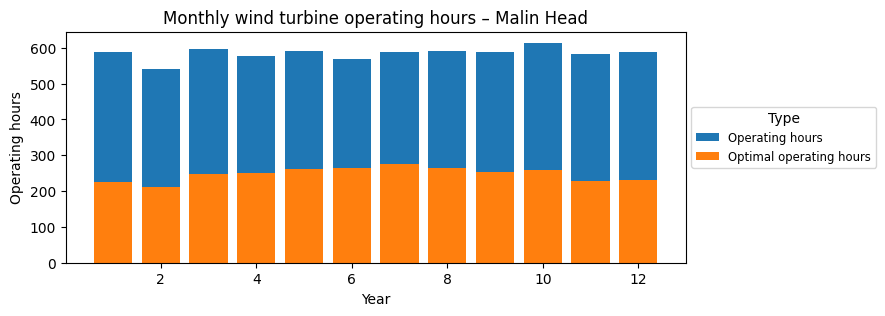

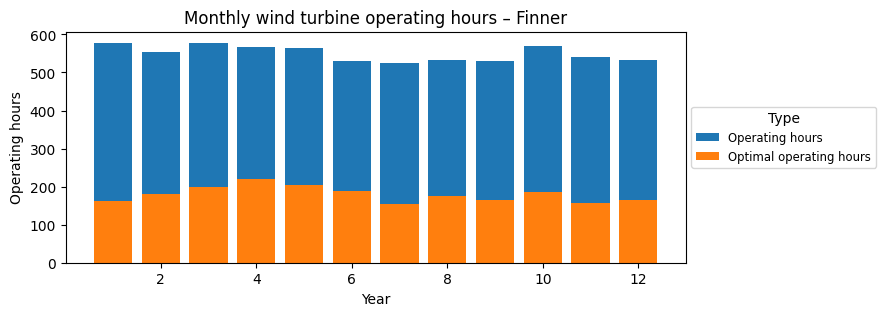

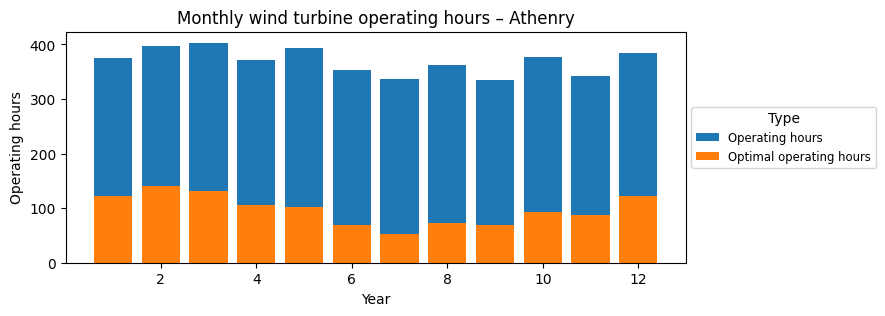

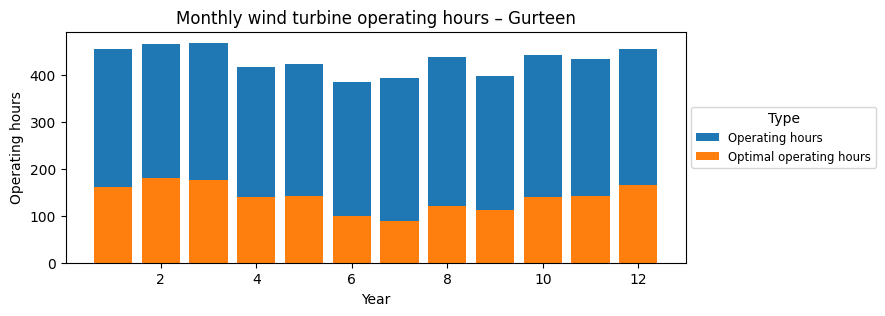

In [4]:
DATADIR = Path("stationdata")

for file in DATADIR.glob("*.csv"):
    df = pd.read_csv(file)
    
    # Study wind range for wind turbines operation
    df["operating"] = (df["wdsp"] >= 7) & (df["wdsp"] <= 27)
    df["optimal"]   = (df["wdsp"] >= 12) & (df["wdsp"] <= 18)

    # Number of hours of operation on average per month
    monthly_operating = (df.groupby(["year", "month"])["operating"].sum().groupby("month").mean())
    # Number of hours of optimal production on average per month
    monthly_optimal = (df.groupby(["year", "month"])["optimal"].sum().groupby("month").mean())


    # Number of hours of operation in total per month
    #monthly_operating = df.groupby("month")["operating"].sum().mean()
    # Number of hours of optimal production in total per month
    #monthly_optimal= df.groupby("month")["optimal"].sum().mean()

    fig, ax = plt.subplots(figsize=(8, 3))

    bars1 = ax.bar(monthly_operating.index, monthly_operating.values, label="Operating hours")

    bars2 = ax.bar(monthly_optimal.index, monthly_optimal.values, label="Optimal operating hours")

    station_name = file.stem.title()

    ax.set_xlabel("Year")
    ax.set_ylabel("Operating hours")
    ax.set_title(f"Monthly wind turbine operating hours – {station_name}")

    # value labels
    #ax.bar_label(bars1, fontsize=8, padding=3)
    #ax.bar_label(bars2, fontsize=8, padding=3)

    # legend
    ax.legend(title="Type", fontsize="small",bbox_to_anchor=(1,0.7))

# put a copy of the image of the plot (.png file) into the `plot` folder in the root of my repository
plt.savefig(f"plot/Operation hours study - average number of operation hours of wind turbines per month.png")

plt.show()

## Study the trend

/tmp/ipykernel_4033/595422614.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Slope: -0.002 m/s per year
P-value: 0.8283, R-squared: 0.000


Slope: -0.011 m/s per year
P-value: 0.0000, R-squared: 0.032


/tmp/ipykernel_4033/595422614.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Slope: 0.044 m/s per year
P-value: 0.0000, R-squared: 0.120


/tmp/ipykernel_4033/595422614.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Slope: -0.008 m/s per year
P-value: 0.0000, R-squared: 0.035
Slope: -0.015 m/s per year
P-value: 0.0000, R-squared: 0.130
Slope: 0.000 m/s per year
P-value: 0.8617, R-squared: 0.000


/tmp/ipykernel_4033/595422614.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Slope: -0.014 m/s per year
P-value: 0.0000, R-squared: 0.062


/tmp/ipykernel_4033/595422614.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Slope: -0.023 m/s per year
P-value: 0.0000, R-squared: 0.041


/tmp/ipykernel_4033/595422614.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Slope: -0.011 m/s per year
P-value: 0.0000, R-squared: 0.049


/tmp/ipykernel_4033/595422614.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Slope: -0.028 m/s per year
P-value: 0.0000, R-squared: 0.077


/tmp/ipykernel_4033/595422614.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Slope: -0.004 m/s per year
P-value: 0.5789, R-squared: 0.001


/tmp/ipykernel_4033/595422614.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Slope: -0.035 m/s per year
P-value: 0.0000, R-squared: 0.296


/tmp/ipykernel_4033/595422614.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Slope: 0.002 m/s per year
P-value: 0.7334, R-squared: 0.000


/tmp/ipykernel_4033/595422614.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Slope: -0.017 m/s per year
P-value: 0.0005, R-squared: 0.034


/tmp/ipykernel_4033/595422614.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Slope: 0.011 m/s per year
P-value: 0.4499, R-squared: 0.002


/tmp/ipykernel_4033/595422614.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Slope: -0.060 m/s per year
P-value: 0.0000, R-squared: 0.288


/tmp/ipykernel_4033/595422614.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Slope: 0.018 m/s per year
P-value: 0.1766, R-squared: 0.007


/tmp/ipykernel_4033/595422614.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Slope: -0.045 m/s per year
P-value: 0.0000, R-squared: 0.104


/tmp/ipykernel_4033/595422614.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Slope: 0.002 m/s per year
P-value: 0.5372, R-squared: 0.000


/tmp/ipykernel_4033/595422614.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


Slope: -0.035 m/s per year
P-value: 0.0000, R-squared: 0.054


/tmp/ipykernel_4033/595422614.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_4033/595422614.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(9,4))


Slope: -0.022 m/s per year
P-value: 0.0173, R-squared: 0.030
Slope: -0.004 m/s per year
P-value: 0.6842, R-squared: 0.001


/tmp/ipykernel_4033/595422614.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


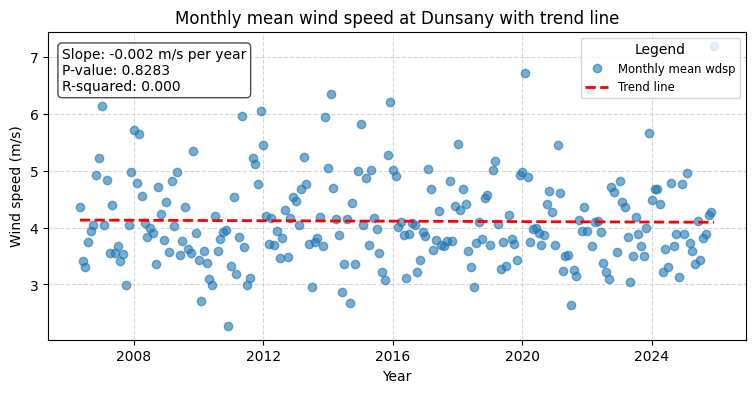

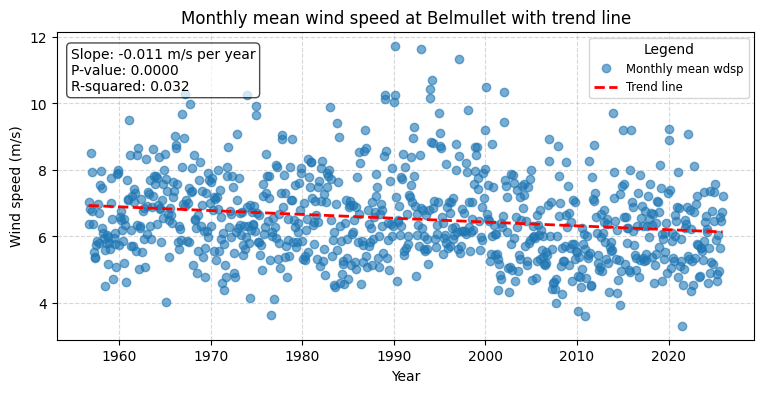

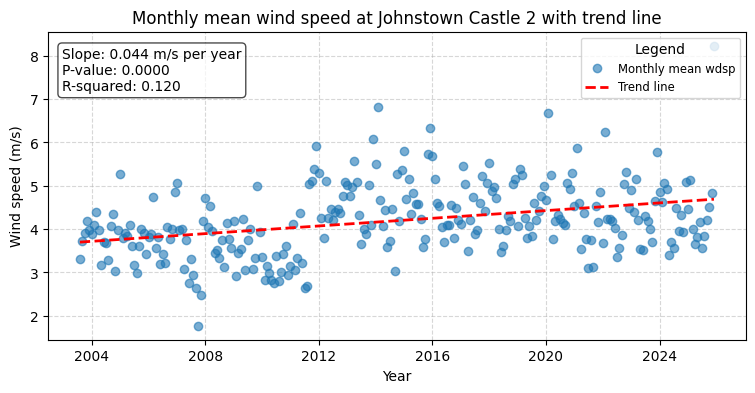

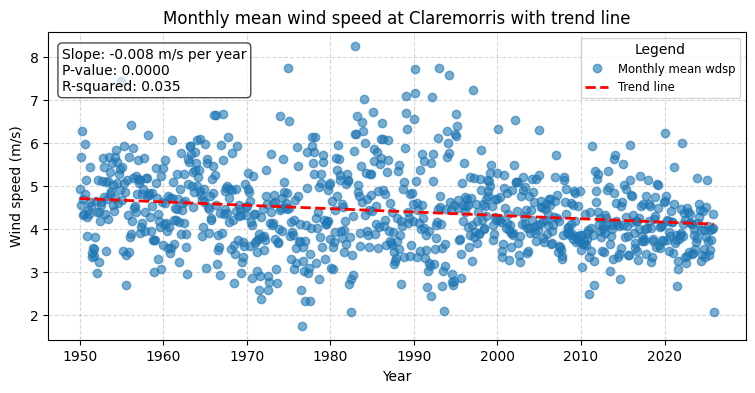

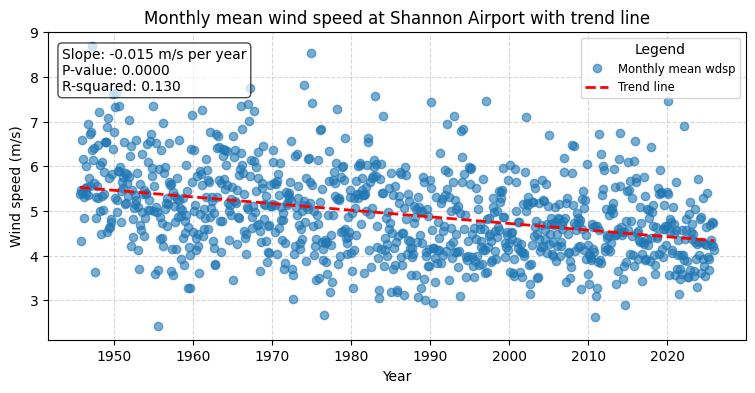

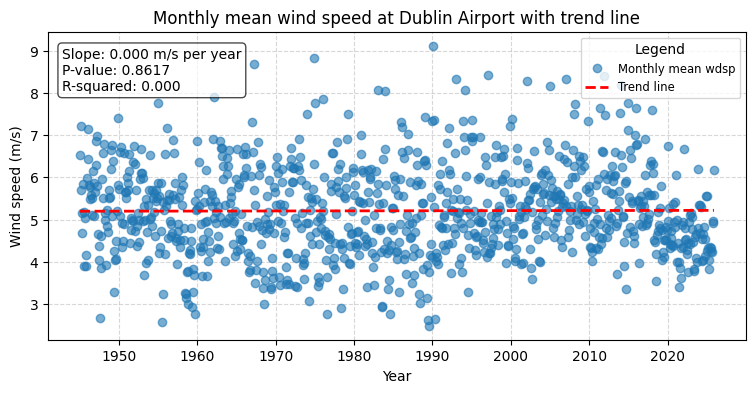

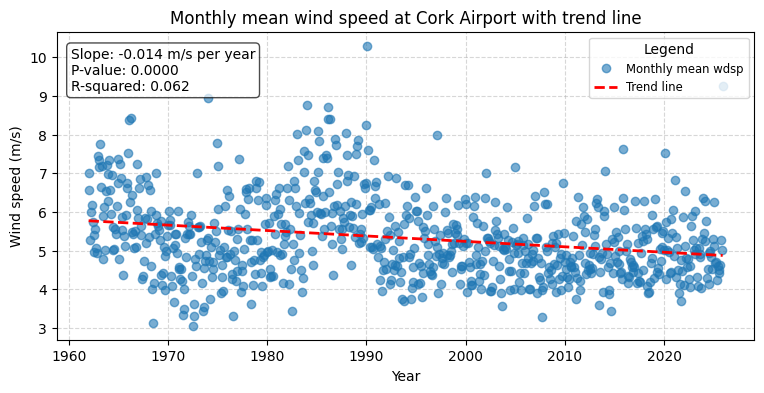

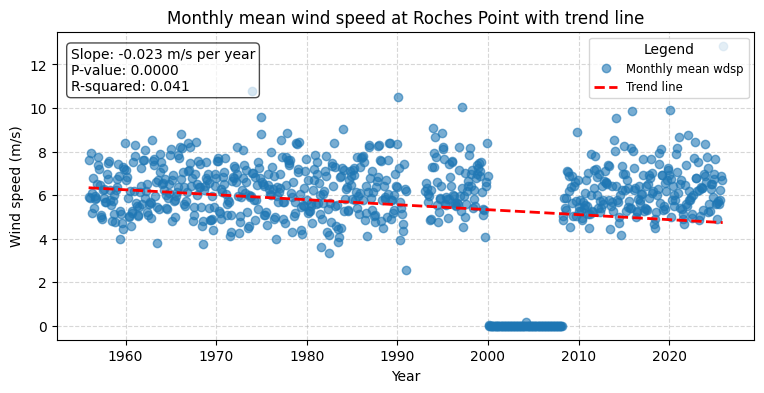

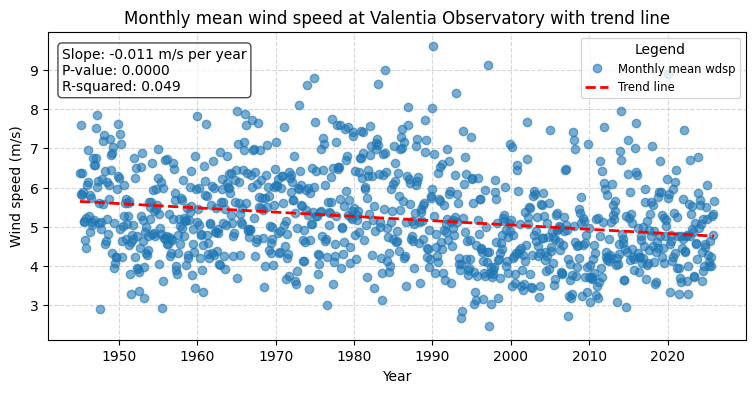

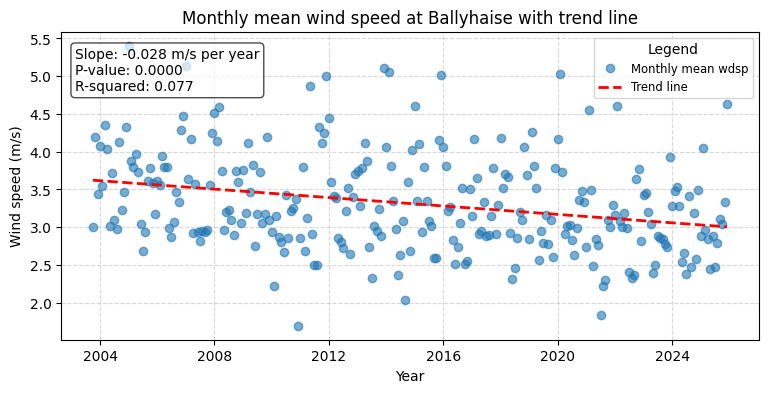

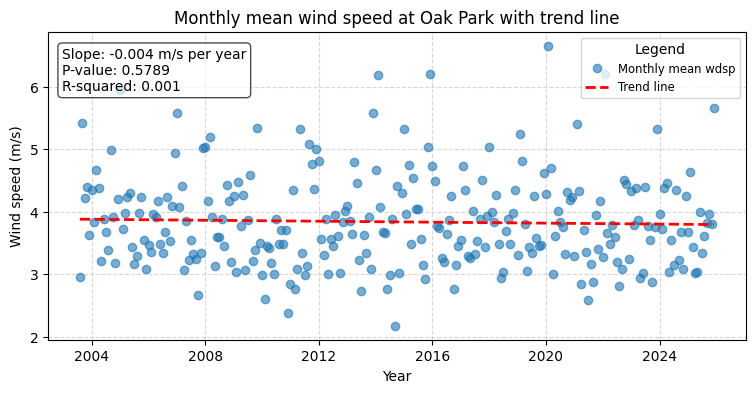

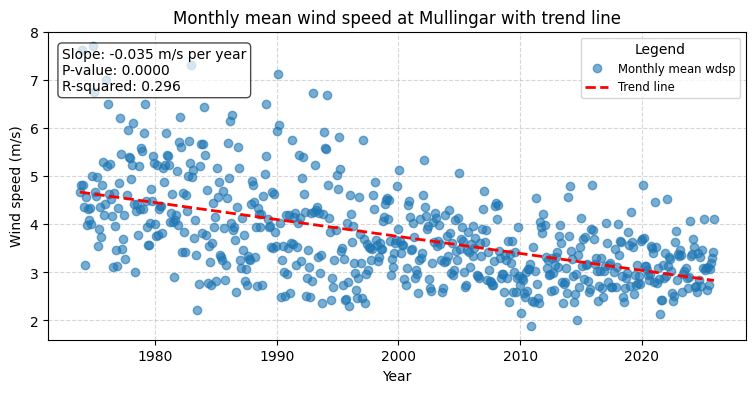

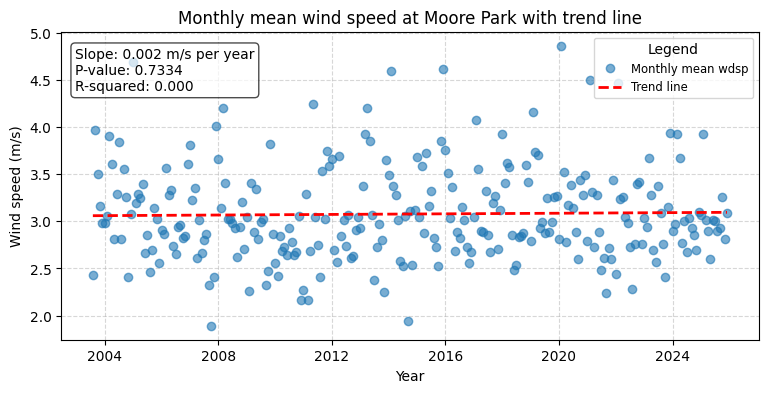

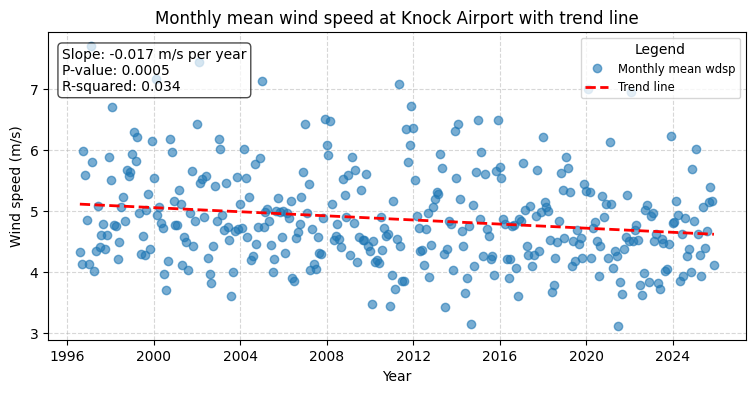

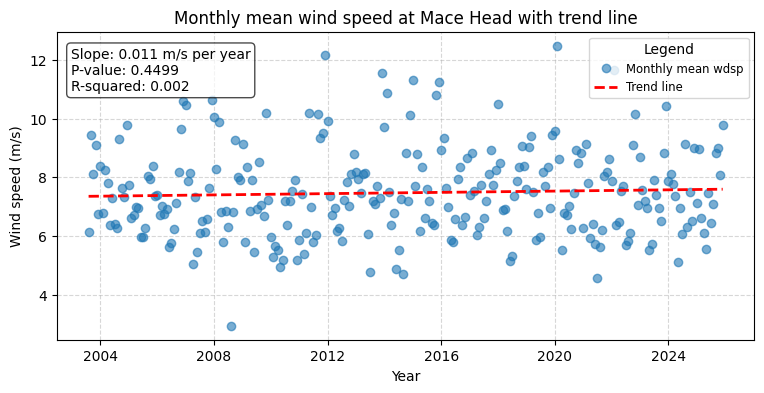

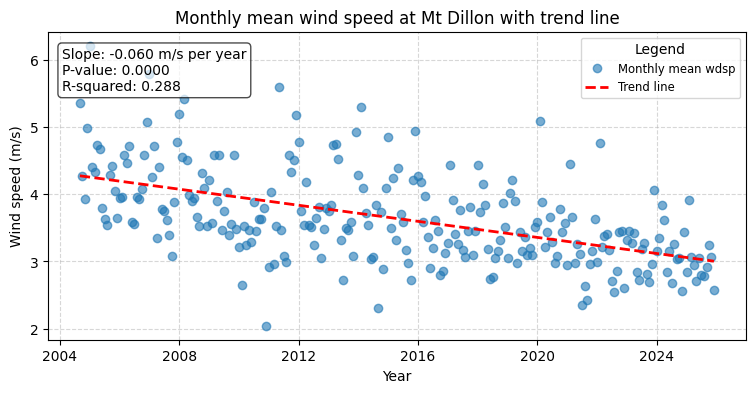

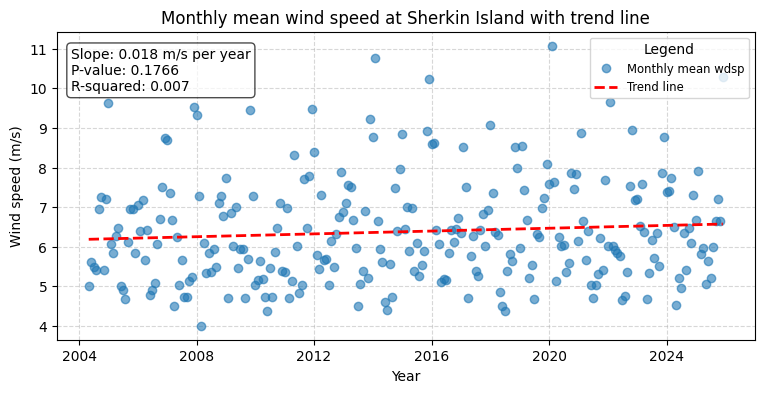

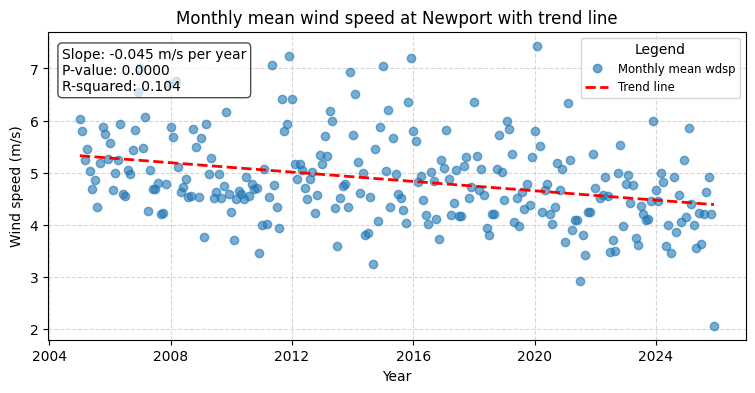

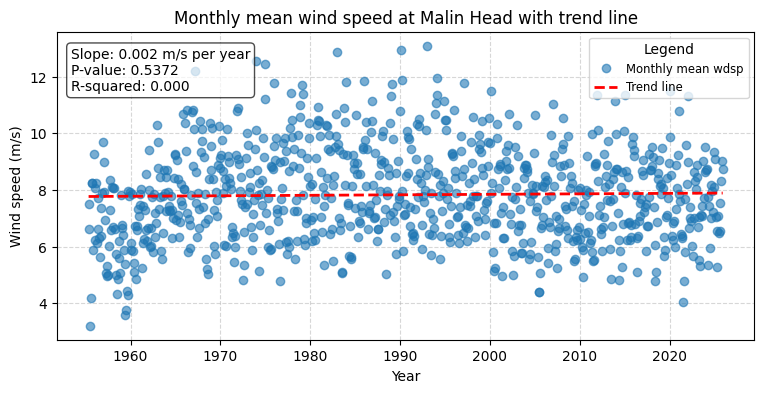

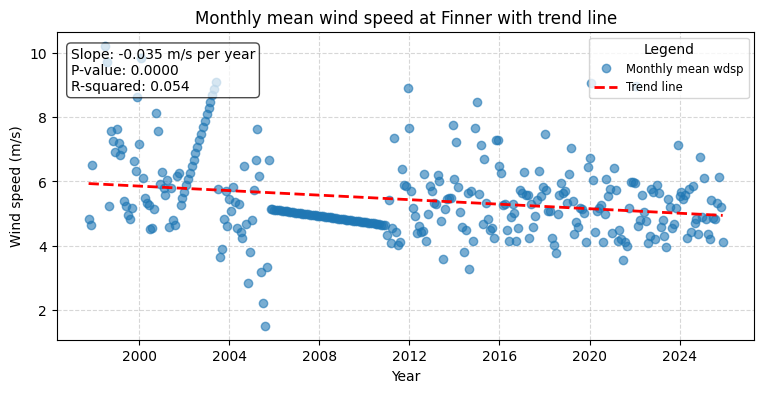

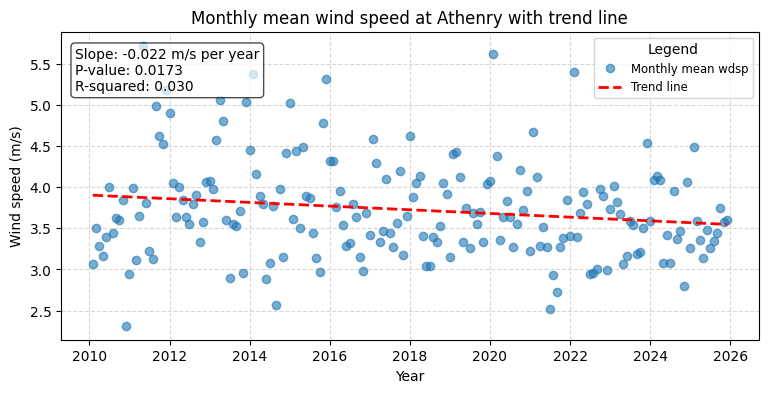

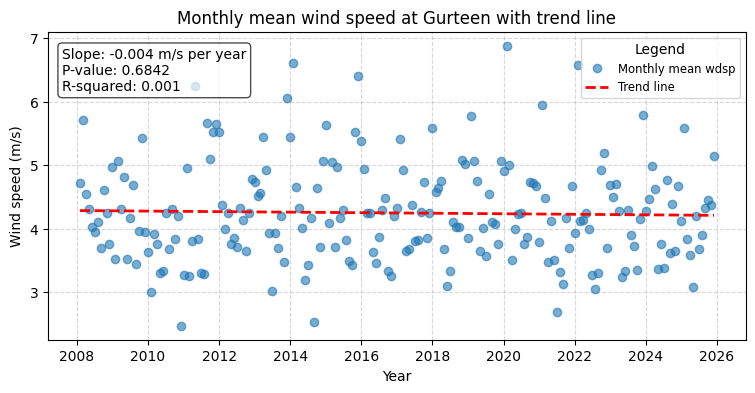

In [5]:
DATADIR = Path("stationdata")

# Read file
for file in DATADIR.glob("*.csv"):
    df = pd.read_csv(file)

    # Calculate monthly mean wind speed 
    df["yearmonth"] = pd.to_datetime(df["yearmonth"], format="%Y-%m")
    monthly_mean = df.groupby("yearmonth")["wdsp_ms"].mean()

    # Convert datetime to numeric decimal years for regression
    X_numeric = monthly_mean.index.year + (monthly_mean.index.month - 1)/12
    Y = monthly_mean.values

    # Compute linear regression trend
    slope, intercept, r_value, p_value, std_err = linregress(X_numeric, Y)
    trend = intercept + slope * X_numeric

    print(f"Slope: {slope:.3f} m/s per year")
    print(f"P-value: {p_value:.4f}, R-squared: {r_value**2:.3f}")

    # Plot
    fig, ax = plt.subplots(figsize=(9,4))

    station_name = file.stem.title()

    # Monthly mean wind speed
    ax.plot(monthly_mean.index, Y, marker='o', linestyle='None', label="Monthly mean wdsp",alpha = 0.6)

    # Trend line
    ax.plot(monthly_mean.index, trend, linestyle='--', color='red', linewidth=2, label="Trend line")

    # Labels and title
    ax.set_xlabel("Year")
    ax.set_ylabel("Wind speed (m/s)")
    ax.set_title(f"Monthly mean wind speed at {station_name} with trend line")
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(title="Legend", fontsize='small',loc="upper right")

    # Add regression details on the plot
    ax.text(0.02, 0.95, f"Slope: {slope:.3f} m/s per year\nP-value: {p_value:.4f}\nR-squared: {r_value**2:.3f}", 
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.7))

# put a copy of the image of the plot (.png file) into the `plot` folder in the root of my repository
#plt.savefig(f"plot/Trend study - monthly mean wind speed.png")

plt.show()

## Is there any other weather metric worth analyzing (eg rain, temp)

In [23]:
# convert 'wdsp' to numeric
df["rain"] = pd.to_numeric(df["rain"], errors="coerce")
corr_wdsp_rain = df["wdsp_ms"].corr(df["rain"])
# convert 'wdsp' to numeric
df["temp"] = pd.to_numeric(df["temp"], errors="coerce")
corr_wdsp_temp = df["wdsp_ms"].corr(df["temp"])

print(f"Correlation coefficient (wdsp_ms vs rain): {corr_wdsp_rain:}")
print(f"Correlation coefficient (wdsp_ms vs temp): {corr_wdsp_temp:}")


Correlation coefficient (wdsp_ms vs rain): 0.14252172403977037
Correlation coefficient (wdsp_ms vs temp): 0.15927152146487308


Wind speed shows a weak correlation with rainfall and temperature.

### try monthly correlation?

In [24]:
monthly = df.groupby("yearmonth")[["wdsp_ms", "rain", "temp"]].mean()

corr_month_wdsp_rain = monthly["wdsp_ms"].corr(monthly["rain"])
corr_month_wdsp_temp = monthly["wdsp_ms"].corr(monthly["temp"])

print(f"Monthly correlation coefficient (wdsp_ms vs rain): {corr_month_wdsp_rain:}")
print(f"Monthly correlation coefficient (wdsp_ms vs temp): {corr_month_wdsp_temp:}")

Monthly correlation coefficient (wdsp_ms vs rain): 0.5065504958709526
Monthly correlation coefficient (wdsp_ms vs temp): -0.379698449504856


Scatter plots show a moderate linear relationship between wind speed and rainfall, suggesting that windier periods often coincide with wetter conditions. Wind speed exhibits a moderate negative relationship with temperature, reflecting stronger winds during cooler conditions

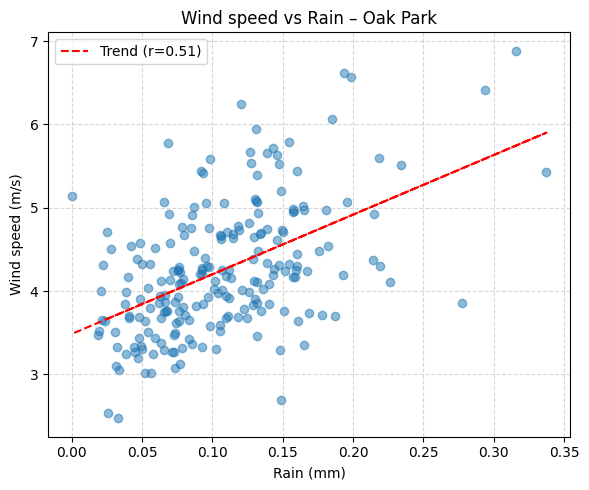

In [43]:
# Scatter plot
plt.figure(figsize=(6,5))
plt.scatter(monthly["rain"], monthly["wdsp_ms"], alpha=0.5)

# Trend line
slope, intercept, r_value, p_value, _ = linregress(monthly["rain"], monthly["wdsp_ms"])
trend = intercept + slope * monthly["rain"]

plt.plot(monthly["rain"], trend, color="red", linestyle="--",
         label=f"Trend (r={r_value:.2f})")

plt.xlabel("Rain (mm)")
plt.ylabel("Wind speed (m/s)")
plt.title("Wind speed vs Rain – Oak Park")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

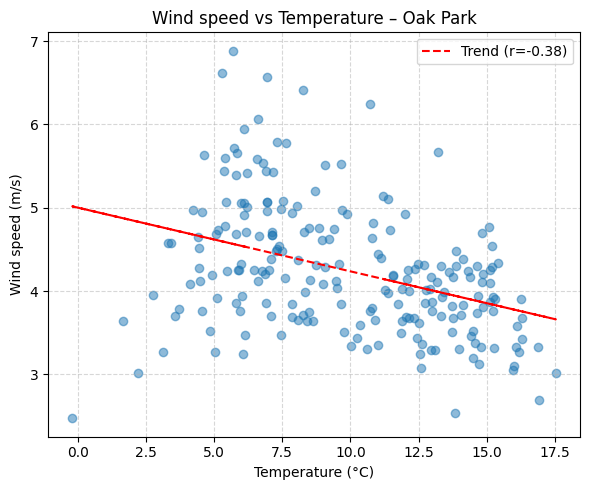

In [27]:
plt.figure(figsize=(6,5))
plt.scatter(monthly["temp"], monthly["wdsp_ms"], alpha=0.5)

# Trend line
slope, intercept, r_value, p_value, _ = linregress(monthly["temp"], monthly["wdsp_ms"])
trend = intercept + slope * monthly["temp"]

plt.plot(monthly["temp"], trend, color="red", linestyle="--",
         label=f"Trend (r={r_value:.2f})")

plt.xlabel("Temperature (°C)")
plt.ylabel("Wind speed (m/s)")
plt.title("Wind speed vs Temperature – Oak Park")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [44]:
DATADIR = Path("stationdata")

results = []

for file in DATADIR.glob("*.csv"):
    df = pd.read_csv(file)

    # convert 'wdsp' to numeric
    df["rain"] = pd.to_numeric(df["rain"], errors="coerce")

    # convert 'wdsp' to numeric
    df["temp"] = pd.to_numeric(df["temp"], errors="coerce")
    
    station = file.stem

    # Correlations
    monthly = df.groupby("yearmonth")[["wdsp_ms", "rain", "temp"]].mean()

    corr_month_wdsp_rain = monthly["wdsp_ms"].corr(monthly["rain"])
    corr_month_wdsp_temp = monthly["wdsp_ms"].corr(monthly["temp"])

    # Trend line
    slope_rain, intercept_rain, r_value_rain, p_value_rain, _ = linregress(monthly["rain"], monthly["wdsp_ms"])
    slope_temp, intercept_temp, r_value_temp, p_value_temp, _ = linregress(monthly["temp"], monthly["wdsp_ms"])

    results.append({
        "station": station,
        "wdsp_vs_rain": corr_month_wdsp_rain,
        "slope (rain x wdsp)": slope_rain,
        "intercept (rain x wdsp)": intercept_rain,
        "R-value (rain x wdsp)": r_value_rain,
        "P-value (rain x wdsp)": p_value_rain,
        "wdsp_vs_temp": corr_month_wdsp_temp,
        "intercept (temp x wdsp)": intercept_temp,
        "slope (temp x wdsp)": slope_temp,
        "R-value (temp x wdsp)": r_value_temp,
        "P-value (temp x wdsp)": p_value_temp,
    })

corr_df = pd.DataFrame(results)
corr_df["P-value (rain x wdsp)"] = corr_df["P-value (rain x wdsp)"].map("{:.3f}".format)
corr_df["P-value (temp x wdsp)"] = corr_df["P-value (temp x wdsp)"].map("{:.3f}".format)
corr_df

/tmp/ipykernel_4033/1051516127.py:6: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)


/tmp/ipykernel_4033/1051516127.py:6: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_4033/1051516127.py:6: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_4033/1051516127.py:6: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_4033/1051516127.py:6: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_4033/1051516127.py:6: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_4033/1051516127.py:6: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/tmp/ipykernel_4033/10515161

station  wdsp_vs_rain  slope (rain x wdsp)  \
0                DUNSANY      0.431360             5.279019   
1              BELMULLET      0.559557            11.031462   
2     JOHNSTOWN CASTLE 2      0.435055             2.251646   
3            CLAREMORRIS      0.411710             5.661585   
4        SHANNON AIRPORT      0.281255             3.261536   
5         DUBLIN AIRPORT      0.203963             4.577393   
6           CORK AIRPORT      0.468827                  NaN   
7           ROCHES POINT      0.603536            19.946760   
8   VALENTIA OBSERVATORY      0.479859             5.554526   
9             BALLYHAISE      0.387834             3.237252   
10              OAK PARK      0.476128             6.301288   
11             MULLINGAR      0.312494             5.352287   
12            MOORE PARK      0.449736             3.316171   
13         KNOCK AIRPORT      0.536648             6.009418   
14             MACE HEAD      0.371316             4.358826   
15             MT DILLON      0.310790             3.479195   
16        SHERKIN ISLAND      0.602584            10.268589   
17               NEWPORT      0.522175             4.955488   
18            MALIN HEAD      0.506696            14.253665   
19                FINNER      0.484758                  NaN   
20               ATHENRY      0.211782             0.839806   
21               GURTEEN      0.506550             7.150225   

    intercept (rain x wdsp)  R-value (rain x wdsp) P-value (rain x wdsp)  \
0                  3.568693               0.431360                 0.000   
1                  5.018755               0.559557                 0.000   
2                  3.901299               0.435055                 0.000   
3                  3.640232               0.411710                 0.000   
4                  4.563383               0.281255                 0.000   
5                  4.810706               0.203963                 0.000   
6                       NaN                    NaN                   nan   
7                  3.556901               0.603536                 0.000   
8                  4.229928               0.479859                 0.000   
9                  2.925864               0.387834                 0.000   
10                 3.227740               0.476128                 0.000   
11                 3.153460               0.312494                 0.000   
12                 2.683197               0.449736                 0.000   
13                 3.922568               0.536648                 0.000   
14                 6.907312               0.371316                 0.000   
15                 3.204395               0.310790                 0.000   
16                 5.057151               0.602584                 0.000   
17                 3.918784               0.522175                 0.000   
18                 6.058722               0.506696                 0.000   
19                      NaN                    NaN                   nan   
20                 3.596710               0.211782                 0.003   
21                 3.487376               0.506550                 0.000   

    wdsp_vs_temp  intercept (temp x wdsp)  slope (temp x wdsp)  \
0      -0.403095                 4.900867            -0.080852   
1      -0.362708                 8.021673            -0.145891   
2      -0.383601                 5.132607            -0.089737   
3      -0.375596                 5.271654            -0.093585   
4      -0.321988                 5.777894            -0.081569   
5      -0.560803                 6.723995            -0.157232   
6      -0.517000                 6.790510            -0.151423   
7      -0.249729                      NaN                  NaN   
8      -0.506406                 7.295742            -0.191654   
9      -0.462204                 4.043610            -0.076666   
10     -0.288591                 4.379517            -0.053161   
11     -0.412630          

In [7]:
oakpark = pd.read_csv("stationdata/OAK PARK.csv")
oakpark.head()

/tmp/ipykernel_4033/4201213406.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  oakpark = pd.read_csv("stationdata/OAK PARK.csv")


date  wdsp  temp rain    dateonly  year yearmonth  month  \
0  2003-08-13 09:00:00   6.0  17.3  0.0  2003-08-13  2003   2003-08      8   
1  2003-08-13 10:00:00   6.0  18.5  0.0  2003-08-13  2003   2003-08      8   
2  2003-08-13 11:00:00   5.0  19.3  0.0  2003-08-13  2003   2003-08      8   
3  2003-08-13 12:00:00   5.0  20.4  0.0  2003-08-13  2003   2003-08      8   
4  2003-08-13 13:00:00   6.0  20.9  0.0  2003-08-13  2003   2003-08      8   

    hour   wdsp_ms   station       rho      power  
0  09:00  3.086667  OAK PARK  1.215312  17.870096  
1  10:00  3.086667  OAK PARK  1.210311  17.796569  
2  11:00  2.572222  OAK PARK  1.207000  10.270767  
3  12:00  2.572222  OAK PARK  1.202478  10.232281  
4  13:00  3.086667  OAK PARK  1.200433  17.651315

In [4]:
from pathlib import Path

data_dir = Path("stationdata")

for file in data_dir.glob("*.csv"):
    size_mb = file.stat().st_size / (1024*1024)
    print(f"{file.name} size: {size_mb:.2f} MB")

DUNSANY.csv size: 20.50 MB
BELMULLET.csv size: 74.07 MB
JOHNSTOWN CASTLE 2.csv size: 25.36 MB
CLAREMORRIS.csv size: 81.64 MB
SHANNON AIRPORT.csv size: 89.54 MB
DUBLIN AIRPORT.csv size: 88.19 MB
CORK AIRPORT.csv size: 68.79 MB
ROCHES POINT.csv size: 71.71 MB
VALENTIA OBSERVATORY.csv size: 93.57 MB
BALLYHAISE.csv size: 23.68 MB
OAK PARK.csv size: 23.48 MB
MULLINGAR.csv size: 55.10 MB
MOORE PARK.csv size: 23.82 MB
KNOCK AIRPORT.csv size: 32.26 MB
MACE HEAD.csv size: 23.91 MB
MT DILLON.csv size: 22.55 MB
SHERKIN ISLAND.csv size: 24.03 MB
NEWPORT.csv size: 21.88 MB
MALIN HEAD.csv size: 76.36 MB
FINNER.csv size: 29.30 MB
ATHENRY.csv size: 16.50 MB
GURTEEN.csv size: 18.68 MB


In [32]:
# change the type on 'wdsp' to numeric, the missing value will be turned into NaN with parameter errors="coerce"
df["wdsp"] = pd.to_numeric(df["wdsp"], errors="coerce")

# count the number of missing values
df["wdsp"].isna().sum()

np.int64(24)